[*********************100%%**********************]  1 of 1 completed
Starting Portfolio Value: 10000.00
1000 USD invested
Buying 0.061662460893414386 units of BTC-USD at 16217.322265625 on Date: 2022-11-28 00:00:00
Total BTC owned: 0.061662460893414386
Average buy price: 16217.322265625
1000 USD invested
Buying 0.060413571011963894 units of BTC-USD at 16552.572265625 on Date: 2022-12-28 00:00:00
Total BTC owned: 0.12207603190537827
Average buy price: 16384.947265625
1000 USD invested
Buying 0.0434195692337752 units of BTC-USD at 23031.08984375 on Date: 2023-01-28 00:00:00
Total BTC owned: 0.16549560113915346
Average buy price: 18600.328125
1000 USD invested
Buying 0.043201483025909496 units of BTC-USD at 23147.353515625 on Date: 2023-02-28 00:00:00
Total BTC owned: 0.20869708416506294
Average buy price: 19737.08447265625
1000 USD invested
Buying 0.03667284733072168 units of BTC-USD at 27268.130859375 on Date: 2023-03-28 00:00:00
Total BTC owned: 0.24536993149578462
Average buy price: 2

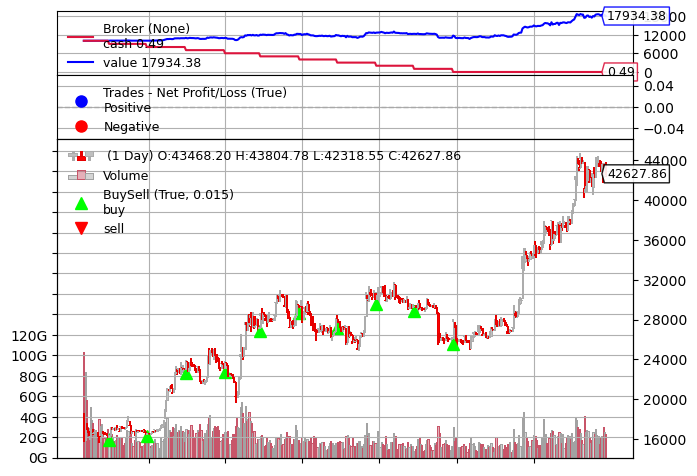

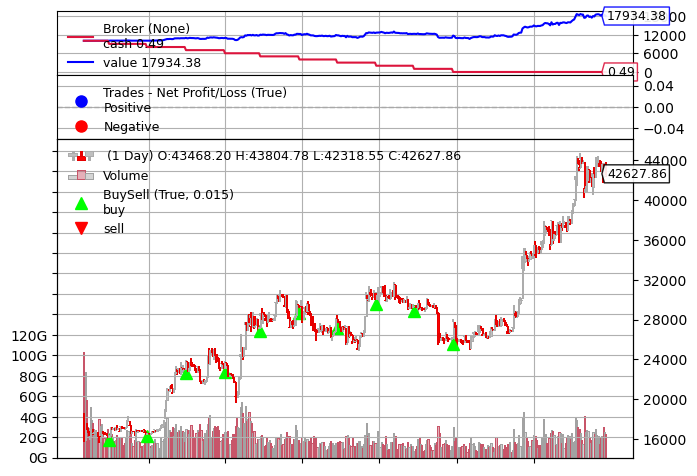

In [17]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import backtrader as bt
import pandas as pd
import numpy as np
from datetime import datetime
import os.path
import sys
# import alpaca
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame
import matplotlib
import yfinance as yf
import matplotlib
import backtrader as bt
import datetime
import random
import matplotlib.pyplot as plt
%matplotlib inline


class DCAStrategy(bt.Strategy):
    params = (
        ("monthly_investment", 1000),  # Dollar amount to invest monthly
        ("crypto_symbol", "BTC-USD"),  # Cryptocurrency symbol
        ("buy_day", random.randint(1, 28)),  # Day of the month to make the purchase
    )

    def __init__(self):
        self.cashflow_date = None
        self.btc_owned = 0
        self.buy_prices = pd.DataFrame(columns=["buying_price", "total_quantity","date"])
        self.sell_price = 0
    

    def buy_crypto(self):
        close_price = self.data.close[0]
        size = self.params.monthly_investment / close_price

        dt = self.data.datetime.datetime()

        # Create a pandas dataframe to store the buying price, total quantity and date
        df = pd.DataFrame(
            data=[[close_price, size, dt]],
            columns=["buying_price", "total_quantity", "date"],
        )

        # Update buy_prices pandas dataframe using concat
        self.buy_prices = pd.concat([self.buy_prices, df])

        # Calculate the average buy price from the dataframe
        average_buy_price = self.buy_prices["buying_price"].mean()
        
        print(f"{self.params.monthly_investment} USD invested")
        print(f"Buying {size} units of {self.params.crypto_symbol} at {close_price} on Date: {dt}")
        self.buy(size=size)
        self.cashflow_date = self.data.datetime.date(0).month
        self.btc_owned += size
        print(f"Total BTC owned: {self.btc_owned}")
        print(f"Average buy price: {average_buy_price}")

    
    def sell_crypto(self):
        close_price = self.data.close[0]
        average_buy_price = self.buy_prices["buying_price"].mean()
        initial_investment = self.params.monthly_investment * months_between_dates(start_date, end_date)

        # Calculate the amount needed to recover the initial investment
        amount_to_recover = initial_investment - (self.btc_owned * average_buy_price)

        # Calculate the amount to sell to outpace the recurring DCA investment per year by about 2X
        amount_to_sell = (self.params.monthly_investment * 12 * 2) / close_price

        # Determine the final sell size based on the minimum of the two amounts
        sell_size = min(amount_to_recover, amount_to_sell)

        print(f"Selling {sell_size} units of {self.params.crypto_symbol} at {close_price}")
        self.sell(size=sell_size)
        self.sell_price = average_buy_price * 3
        self.btc_owned -= sell_size
        print(f"Total BTC owned: {self.btc_owned}")

    def next(self):
        dt = self.data.datetime.datetime()
        if dt.month != self.cashflow_date:
            if dt.day == self.params.buy_day:
                self.buy_crypto()
                self.sell_price = self.buy_prices["buying_price"].mean() * 2  # Update sell_price after buying
            if self.data.close[0] > self.sell_price and self.btc_owned > 0:  # Check if btc_owned is greater than 0
                self.sell_crypto()




cerebro = bt.Cerebro()
filename = 'btcusd.csv'
datapath = os.getcwd() + '/' + filename



def download_yahoo_data(symbol, start_date, end_date):
    data = yf.download(symbol, start=start_date, end=end_date)
    return data

start_date = datetime.datetime(2022, 11, 9)
end_date = datetime.datetime(2023, 12, 29)


data = bt.feeds.PandasData(dataname=download_yahoo_data("BTC-USD", start_date, end_date))



# Function to calculate the months between two dates, the first date will be the start date and the second date will be the end date of the investment period
def months_between_dates(start_date, end_date):
    months = (end_date.year - start_date.year) * 12 + (end_date.month - start_date.month)
    return months


cerebro.adddata(data)
cerebro.addstrategy(DCAStrategy)

initial_cash = 10000

# Set our desired cash start
cerebro.broker.setcash(initial_cash)


# # Set the commission
# cerebro.broker.setcommission(commission=0.0)
# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
# Run over everything
cerebro.run()
# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Total investment amount
total_investment = initial_cash + (100 * months_between_dates(start_date, end_date))
print(f"Total investment: ${total_investment}")

# Print the total net profit at the end of the backtest
# It would be the final portfolio value minus the starting cash and the amount invested over the period which is from 2021-01-01 to 2023-12-29
net_profit = cerebro.broker.getvalue() - (initial_cash + total_investment)

print(f"Net Profit: ${net_profit}")
print(cerebro.broker.getvalue())
# Plot the result
cerebro.plot(style='candlestick', iplot=False)[0][0].figure